Install required libaries.

In [36]:
# install required libraries
!pip install sdv # install the synthetic data vault library

Import required libraries.

In [37]:
# import data science libraries
import pandas as pd
import numpy as np
import math

# import scikit-learn preprocessing
from sklearn.preprocessing import LabelEncoder, QuantileTransformer

# import pytorch libraries
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

# import synthetic data vault libraries
from sdv.metadata import SingleTableMetadata
import sdv.evaluation.single_table as sdv_st

# import utility libraries
from tqdm import tqdm
import xlrd
import requests
from io import BytesIO
from zipfile import ZipFile
from datetime import datetime

# import visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

Init and set experiment parameters.

In [38]:
# set random seed
seed = 1234

# set dimension of categorical embeddings
cat_emb_dim = 2

# set number of neurons per layer
mlp_layers = [1024, 1024, 1024, 1024]

# set non-linear activation function
activation = 'lrelu'

# set number of diffusion steps
diffusion_steps = 500

# set diffusion start and end betas
diffusion_beta_start = 1e-4
diffusion_beta_end = 0.02

# set diffusion scheduler
scheduler = 'linear'

# set number of training epochs
epochs = 500

# set training batch size
batch_size = 512

# set training learning rate
learning_rate = 1e-4

# set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu").type

Set random seed values.

In [39]:
# set numpy seed
np.random.seed(seed)

# set pytorch seed
torch.manual_seed(seed)

# set cuda seed
torch.cuda.manual_seed(seed)

## Load, pre-process, and init the UCU Credit Card dataset
The dataset is available under https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients.

In [40]:
# set data path
data_url = 'https://archive.ics.uci.edu/static/public/350/default+of+credit+card+clients.zip'

# download the file
response = requests.get(data_url)

# determine the zip file
zip_file = ZipFile(BytesIO(response.content))

# extract the zip file
zip_file.extractall('data')

# read the UCI credit card dataset
train_raw = pd.read_excel('data/default of credit card clients.xls', skiprows=[0])

Inspect the top 10 rows and attribute names of the dataset retreived.

In [41]:
# display top 10 rows
train_raw.head(10)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,6,50000,1,1,2,37,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,7,500000,1,1,2,29,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,8,100000,2,2,2,23,0,-1,-1,0,...,221,-159,567,380,601,0,581,1687,1542,0
8,9,140000,2,3,1,28,0,0,2,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,10,20000,1,3,2,35,-2,-2,-2,-2,...,0,13007,13912,0,0,0,13007,1122,0,0


In [42]:
# display attribute names
train_raw.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [43]:
train_raw.dtypes

,0
ID,int64
LIMIT_BAL,int64
SEX,int64
EDUCATION,int64
MARRIAGE,int64
AGE,int64
PAY_0,int64
PAY_2,int64
PAY_3,int64
PAY_4,int64


Set numerical and categorical dataset attributes.

In [44]:
# determine categorical attributes
cat_attrs = ['SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY0', 'PAY2', 'PAY3', 'PAY4', 'PAY5', 'PAY6']

# determine numerical attributes
num_attrs = ['LIMITBAL', 'BILLAMT1', 'BILLAMT2', 'BILLAMT3', 'BILLAMT4', 'BILLAMT5', 'BILLAMT6',
             'PAYAMT1', 'PAYAMT2', 'PAYAMT3', 'PAYAMT4', 'PAYAMT5', 'PAYAMT6']

Pre-process dataset attributes.

In [45]:
# remove underscore in column names for correct inverse decoding
train_raw.columns = [col.replace('_', '') for col in train_raw.columns]

# convert categorical attributes to string
train_raw[cat_attrs] = train_raw[cat_attrs].astype(str)

# iterate over categorical attributes
for cat_attr in cat_attrs:

    # add col name to every categorical entry to make them distinguishable for embedding
    train_raw[cat_attr] = cat_attr + '_' + train_raw[cat_attr].astype('str')

In [46]:
train_raw.head()

,ID,LIMITBAL,SEX,EDUCATION,MARRIAGE,AGE,PAY0,PAY2,PAY3,PAY4,...,BILLAMT4,BILLAMT5,BILLAMT6,PAYAMT1,PAYAMT2,PAYAMT3,PAYAMT4,PAYAMT5,PAYAMT6,default payment next month
0,1,20000,SEX_2,EDUCATION_2,MARRIAGE_1,AGE_24,PAY0_2,PAY2_2,PAY3_-1,PAY4_-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,SEX_2,EDUCATION_2,MARRIAGE_2,AGE_26,PAY0_-1,PAY2_2,PAY3_0,PAY4_0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,SEX_2,EDUCATION_2,MARRIAGE_2,AGE_34,PAY0_0,PAY2_0,PAY3_0,PAY4_0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,SEX_2,EDUCATION_2,MARRIAGE_1,AGE_37,PAY0_0,PAY2_0,PAY3_0,PAY4_0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,SEX_1,EDUCATION_2,MARRIAGE_1,AGE_57,PAY0_-1,PAY2_0,PAY3_-1,PAY4_0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Set dataset label.

In [47]:
# extract label
label = train_raw['default payment next month']

In [48]:
label

,default payment next month
0,1
1,1
2,0
3,0
4,0
...,...
29995,0
29996,0
29997,1
29998,1


Determine the training data.

In [49]:
# merge selected categorical and numerical attributes
train = train_raw[[*cat_attrs, *num_attrs]]

In [50]:
train

,SEX,EDUCATION,MARRIAGE,AGE,PAY0,PAY2,PAY3,PAY4,PAY5,PAY6,...,BILLAMT3,BILLAMT4,BILLAMT5,BILLAMT6,PAYAMT1,PAYAMT2,PAYAMT3,PAYAMT4,PAYAMT5,PAYAMT6
0,SEX_2,EDUCATION_2,MARRIAGE_1,AGE_24,PAY0_2,PAY2_2,PAY3_-1,PAY4_-1,PAY5_-2,PAY6_-2,...,689,0,0,0,0,689,0,0,0,0
1,SEX_2,EDUCATION_2,MARRIAGE_2,AGE_26,PAY0_-1,PAY2_2,PAY3_0,PAY4_0,PAY5_0,PAY6_2,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,SEX_2,EDUCATION_2,MARRIAGE_2,AGE_34,PAY0_0,PAY2_0,PAY3_0,PAY4_0,PAY5_0,PAY6_0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,SEX_2,EDUCATION_2,MARRIAGE_1,AGE_37,PAY0_0,PAY2_0,PAY3_0,PAY4_0,PAY5_0,PAY6_0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,SEX_1,EDUCATION_2,MARRIAGE_1,AGE_57,PAY0_-1,PAY2_0,PAY3_-1,PAY4_0,PAY5_0,PAY6_0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,SEX_1,EDUCATION_3,MARRIAGE_1,AGE_39,PAY0_0,PAY2_0,PAY3_0,PAY4_0,PAY5_0,PAY6_0,...,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000
29996,SEX_1,EDUCATION_3,MARRIAGE_2,AGE_43,PAY0_-1,PAY2_-1,PAY3_-1,PAY4_-1,PAY5_0,PAY6_0,...,3502,8979,5190,0,1837,3526,8998,129,0,0
29997,SEX_1,EDUCATION_2,MARRIAGE_2,AGE_37,PAY0_4,PAY2_3,PAY3_2,PAY4_-1,PAY5_0,PAY6_0,...,2758,20878,20582,19357,0,0,22000,4200,2000,3100
29998,SEX_1,EDUCATION_3,MARRIAGE_1,AGE_41,PAY0_1,PAY2_-1,PAY3_0,PAY4_0,PAY5_0,PAY6_-1,...,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804


Transform the numerical attributes.

In [51]:
# init the quantile transformation
num_scaler = QuantileTransformer(output_distribution='normal', random_state=seed)

# fit transformation to numerical attributes
num_scaler.fit(train[num_attrs])

# transform numerical attributes
train_num_scaled = num_scaler.transform(train[num_attrs])

Transform the categorical attributes.

In [52]:
# get vocabulary of categorical attributes
vocabulary_classes = np.unique(train[cat_attrs])

# init categorical attribute encoder
label_encoder = LabelEncoder()

# fit encoder to categorical attributes
label_encoder.fit(vocabulary_classes)

# transform categorical attributes
train_cat_scaled = train[cat_attrs].apply(label_encoder.transform)

# collect unique values of each categorical attribute
vocab_per_attr = {cat_attr: set(train_cat_scaled[cat_attr]) for cat_attr in cat_attrs}

Convert numerical and categorical attributes as well as the labels to tensors.

In [53]:
# convert numerical attributes
train_num_torch = torch.FloatTensor(train_num_scaled)

# convert categorical attributes
train_cat_torch = torch.LongTensor(train_cat_scaled.values)

# convert label
label_torch = torch.LongTensor(label)

Convert dataset to tensor dataset.

In [54]:
# init tensor dataset
train_set = TensorDataset(
    train_cat_torch, # categorical attributes
    train_num_torch, # numerical attributes
    label_torch # dataset labels
)

Init the data loader.

In [55]:
# init the data loader
dataloader = DataLoader(
    dataset=train_set, # training dataset
    batch_size=batch_size, # training batch size
    num_workers=0, # number of workers
    shuffle=True # shuffle training data
)

## Implement the FinDiff model

Implement the FinDiff backbone model.

In [56]:
# define base feedforward network
class BaseNetwork(nn.Module):

    # define base network constructor
    def __init__(self, hidden_size, activation='lrelu'):

        # call super calass constructor
        super(BaseNetwork, self).__init__()

        # init
        self.layers = self.init_layers(hidden_size)

        # case: lrelu activation
        if activation == 'lrelu':

            # set lrelu activation
            self.activation = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # case: relu activation
        elif activation == 'relu':

            # set relu activation
            self.activation = nn.ReLU(inplace=True)

        # case: tanh activation
        elif activation == 'tanh':

            # set tanh activation
            self.activation = nn.Tanh()

        # case: sigmoid activation
        else:

            # set sigmoid activation
            self.activation = nn.Sigmoid()

    # define layer initialization
    def init_layers(self, layer_dimensions):

        # init layers
        layers = []

        # iterate over layer dimensions
        for i in range(len(layer_dimensions)-1):

            # init linear layer
            layer = nn.Linear(layer_dimensions[i], layer_dimensions[i + 1], bias=True)

            # init linear layer weights
            nn.init.xavier_uniform_(layer.weight)

            # init linear layer bias
            nn.init.constant_(layer.bias, 0.0)

            # collecet linear layer
            layers.append(layer)

            # register linear layer parameters
            self.add_module('linear_' + str(i), layer)

        # return layers
        return layers

    # define forward pass
    def forward(self, x):

        # iterate over layers
        for i in range(len(self.layers)):

            # run layer forward pass
            x = self.activation(self.layers[i](x))

        # return forward pass result
        return x

Implement the FinDiff model synthesizer.

In [57]:
# define MLP synthesizer network
class MLPSynthesizer(nn.Module):

    # define MLP synthesizer network constructor
    def __init__(
            self,
            d_in: int,
            hidden_layers: list,
            activation: str='lrelu', # layer activation
            dim_t: int=64,
            n_cat_tokens=None, # number of categorical tokens
            n_cat_emb=None, # number of categorical dimensions
            embedding=None,
            embedding_learned=True,
            n_classes=None
        ):

        # call super class constructor
        super(MLPSynthesizer, self).__init__()

        # init ???
        self.dim_t = dim_t

        # init synthesizer base feed forward network
        self.backbone = BaseNetwork([dim_t, *hidden_layers], activation=activation)

        # case: categorical embedding defined
        if embedding is not None:

            # init pretrained embedding layer
            self.cat_embedding = nn.Embedding.from_pretrained(embeddings=embedding)

        # case: categorical embedding undefined
        else:

            # init new categorical embedding layer
            self.cat_embedding = nn.Embedding(n_cat_tokens, n_cat_emb, max_norm=None, scale_grad_by_freq=False)

            # activate categorical embedding layer learning
            self.cat_embedding.weight.requires_grad = embedding_learned

        # case: data classes available
        if n_classes is not None:

            # init label embedding layer
            self.label_embedding = nn.Embedding(n_classes, dim_t)

        # define input data projection
        self.projection = nn.Sequential(
            nn.Linear(d_in, dim_t), # linear layer
            nn.SiLU(), # silu activation
            nn.Linear(dim_t, dim_t) # linear layer
        )

        # define time embedding projection
        self.time_embed = nn.Sequential(
            nn.Linear(dim_t, dim_t), # linear layer
            nn.SiLU(), # silu activation
            nn.Linear(dim_t, dim_t) # linear layer
        )

        # define output data projection
        self.head = nn.Linear(hidden_layers[-1], d_in)

    # define sinusodial time step embedding
    def embed_time(self, timesteps, dim_out, max_period=10000):

        # half output dimension
        half_dim_out = dim_out // 2

        # determine tensor of frequencies
        freqs = torch.exp(-math.log(max_period) * torch.arange(start=0, end=half_dim_out, dtype=torch.float32) / half_dim_out)

        # push to compute device
        freqs = freqs.to(device=timesteps.device)

        # create timestep vs. frequency grid
        args = timesteps[:, None].float() * freqs[None]

        # creating the time embedding
        time_embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)

        # case: odd output dimension
        if dim_out % 2:

            # append additional dimension
            time_embedding = torch.cat([time_embedding, torch.zeros_like(time_embedding[:, :1])], dim=-1)

        # return timestep embedding
        return time_embedding

    # get categorical embeddings
    def get_embeddings(self):

        # return categorical embeddings
        return self.cat_embedding.weight.data

    # perform categorical embedding
    def embed_categorical(self, x_cat):

        # perform categorical embedding
        x_cat_emb = self.cat_embedding(x_cat)

        # reshape embedding to original input
        x_cat_emb = x_cat_emb.view(-1, x_cat_emb.shape[1] * x_cat_emb.shape[2])

        # return categorical embedding
        return x_cat_emb

    # define forward pass
    def forward(self, x, timesteps, label=None):

        # init time embeddings
        time_emb = self.embed_time(timesteps, self.dim_t)

        # embedd time embeddings
        time_emb  = self.time_embed(time_emb )

        # case: data classes available
        if label is not None:

            # determine label embeddings
            time_label_emb = time_emb  + self.label_embedding(label)

        # run initial projection layer
        x = self.projection(x)

        # add time and label embedding
        x = x + time_label_emb

        # run backbone forward pass
        x =  self.backbone(x)

        # run projection forward pass
        x = self.head(x)

        # return forward pass result
        return x

Implement the FinDiff model base diffuser.

In [58]:
# define BaseDiffuser network
class BaseDiffuser(object):

    # define base diffuser network constructor
    def __init__(
            self,
            total_steps=1000,
            beta_start=1e-4,
            beta_end=0.02,
            device='cpu',
            scheduler='linear'
        ):

        # set diffusion steps
        self.total_steps = total_steps

        # set diffusion start beta
        self.beta_start = beta_start

        # set diffusion end beta
        self.beta_end = beta_end

        # set compute device
        self.device = device

        # set noise schedule alphas and betas
        self.alphas, self.betas = self.prepare_noise_schedule(scheduler=scheduler)

        # set noise schedule alhpa hats
        self.alphas_hat = torch.cumprod(self.alphas, dim=0)

    # define noise schedule
    def prepare_noise_schedule(self, scheduler: str):

        # determine noise scheduler scale
        scale = 1000 / self.total_steps

        # scale beta start
        beta_start = scale * self.beta_start

        # scale beta end
        beta_end = scale * self.beta_end

        # case: linear noise scheduler
        if scheduler == 'linear':

            # determine linear noise schedule betas
            betas = torch.linspace(beta_start, beta_end, self.total_steps)

            # determine linear noise schedule alphas
            alphas = 1.0 - betas

        # case: quadratic noise scheduler
        elif scheduler == 'quad':

            # determine quadratic noise schedule betas
            betas = torch.linspace(self.beta_start ** 0.5, self.beta_end ** 0.5, self.total_steps) ** 2

            # determine quadratic noise schedule alphas
            alphas = 1.0 - betas

        # return noise scheduler alphas and betas
        return alphas.to(self.device), betas.to(self.device)

    # define random timesteps sampler
    def sample_random_timesteps(self, n: int):

        # sample random timesteps
        t = torch.randint(low=1, high=self.total_steps, size=(n,), device=self.device)

        # return random timesteps
        return t

    # define gaussian noise addition
    def add_gauss_noise(self, x_num, t):

        # determine noise alpha hat
        sqrt_alpha_hat = torch.sqrt(self.alphas_hat[t])[:, None]

        # determine noise one minius alpha hat
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alphas_hat[t])[:, None]

        # determine numeric noise
        noise_num = torch.randn_like(x_num)

        # determine x numeric noise
        x_noise_num = sqrt_alpha_hat * x_num + sqrt_one_minus_alpha_hat * noise_num

        # return x numeric noise and numeric noise
        return x_noise_num, noise_num

    # define gaussian noise sampling
    def p_sample_gauss(self, model_out, z_norm, timesteps):

        # determine noise alpha hat
        sqrt_alpha_t = torch.sqrt(self.alphas[timesteps])[:, None]

        # determine noise betas
        betas_t = self.betas[timesteps][:, None]

        # determine noise one minius alpha hat
        sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - self.alphas_hat[timesteps])[:, None]

        epsilon_t = torch.sqrt(self.betas[timesteps][:, None])

        # determine random noise
        random_noise = torch.randn_like(z_norm)
        random_noise[timesteps == 0] = 0.0

        # determine model mean
        model_mean = ((1 / sqrt_alpha_t) * (z_norm - (betas_t * model_out / sqrt_one_minus_alpha_hat_t)))

        # determine z norm
        z_norm = model_mean + (epsilon_t * random_noise)

        # return z norm
        return z_norm

## Initialize and train the FinDiff model

In [59]:
# determine number unique categorical tokens
n_cat_tokens = len(np.unique(train[cat_attrs]))

# determine total categorical embedding dimension
cat_dim = cat_emb_dim * len(cat_attrs)

# determine total numerical embedding dimension
num_dim = len(num_attrs)

# determine total embedding dimension
encoded_dim = cat_dim + num_dim

In [60]:
# initialize the FinDiff synthesizer model
synthesizer_model = MLPSynthesizer(
    d_in=encoded_dim,
    hidden_layers=mlp_layers,
    activation=activation,
    n_cat_tokens=n_cat_tokens,
    n_cat_emb=cat_emb_dim,
    n_classes=pd.Series(label).nunique(),
    embedding_learned=False
)

In [61]:
# initialize the FinDiff base diffuser model
diffuser_model = BaseDiffuser(
    total_steps=diffusion_steps,
    beta_start=diffusion_beta_start,
    beta_end=diffusion_beta_end,
    scheduler=scheduler,
    device=device
)

Init optimizer, scheduler and loss function.

In [62]:
# determine synthesizer model parameters
parameters = filter(lambda p: p.requires_grad, synthesizer_model.parameters())

# init Adam optimizer
optimizer = optim.Adam(parameters, lr=learning_rate)

# init learning rate scheduler
lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, verbose=False)

# int mean-squared-error loss
loss_fnc = nn.MSELoss()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.



In [63]:
# init collection of training epoch losses
train_epoch_losses = []

# set the model in training mode
synthesizer_model.train()

# move to the device
synthesizer_model = synthesizer_model.to(device)

# init the training progress bar
pbar = tqdm(iterable=range(epochs), position=0, leave=True)

# iterate over training epochs
for epoch in pbar:

    base_params = {'epoch': epoch, 'seed': seed, 'mlp_layers': mlp_layers}

    # init epoch training batch losses
    batch_losses = []

    # iterate over epoch batches
    for batch_cat, batch_num, batch_y in dataloader:

        # move tensors to device
        batch_cat = batch_cat.to(device)
        batch_num = batch_num.to(device)
        batch_y = batch_y.to(device)

        # sample diffusion timestep
        timesteps = diffuser_model.sample_random_timesteps(n=batch_cat.shape[0])

        # determine categorical embeddings
        batch_cat_emb = synthesizer_model.embed_categorical(x_cat=batch_cat)

        # concatenate categorical and numerical embeddings
        batch_cat_num = torch.cat((batch_cat_emb, batch_num), dim=1)

        # add diffuser gaussian noise
        batch_noise_t, noise_t = diffuser_model.add_gauss_noise(x_num=batch_cat_num, t=timesteps)

        # conduct synthesizer model forward pass
        predicted_noise = synthesizer_model(x=batch_noise_t, timesteps=timesteps, label=batch_y)

        # compute training batch loss
        batch_loss = loss_fnc(input=noise_t, target=predicted_noise)

        # reset model gradients
        optimizer.zero_grad()

        # run model backward pass
        batch_loss.backward()

        # optimize model parameters
        optimizer.step()

        # collect training batch losses
        batch_losses.append(batch_loss.detach().cpu().numpy())

    # determine mean training epoch loss
    batch_losses_mean = np.mean(np.array(batch_losses))

    # update learning rate scheduler
    lr_scheduler.step()

    # collect mean training epoch loss
    train_epoch_losses.append(batch_losses_mean)

    # prepare and set training epoch progress bar update
    now = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')
    pbar.set_description('[LOG {}] epoch: {}, train-loss: {}'.format(str(now), str(epoch).zfill(4), str(batch_losses_mean)))


[LOG 2024-12-09 19:43:46] epoch: 0499, train-loss: 0.14323656: 100%|██████████| 500/500 [04:31<00:00,  1.84it/s]


Visualize training loss progression.

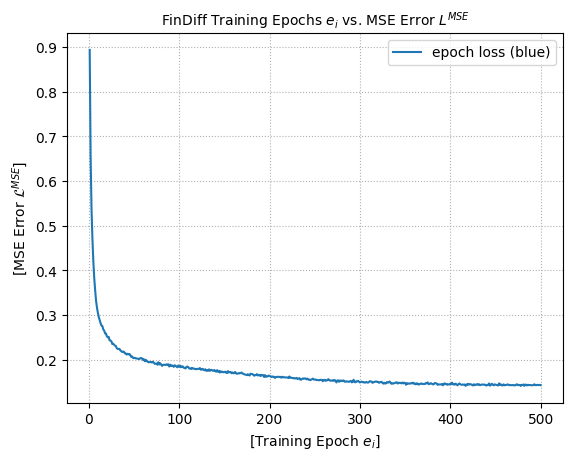

In [64]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

# add axis legends
ax.set_xlabel('[Training Epoch $e_i$]', fontsize=10)
ax.set_ylabel('[MSE Error $\mathcal{L}^{MSE}$]', fontsize=10)

# set plot legend
plt.legend(loc='upper right', numpoints=1, fancybox=True)

# add plot title
plt.title('FinDiff Training Epochs $e_i$ vs. MSE Error $L^{MSE}$', fontsize=10);

## Generate Data using the FinDiff model

Init and set sampling parameters.

Use FinDiff to generate new data samples.

In [65]:
# init samples to be generated
samples = torch.randn((len(label_torch), encoded_dim), device=device)

# init the generation progress bar
pbar = tqdm(iterable=reversed(range(0, diffusion_steps)), position=0, leave=True)

with torch.no_grad():
  # iterate over diffusion steps
  for diffusion_step in pbar:

      # prepare and set training epoch progress bar update
      now = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')
      pbar.set_description('[LOG {}] Diffusion Step: {}'.format(str(now), str(diffusion_step).zfill(4)))

      # init diffusion timesteps
      timesteps = torch.full((len(label_torch),), diffusion_step, dtype=torch.long, device=device)

      # run synthesizer model forward pass
      model_out = synthesizer_model(x=samples.float(), timesteps=timesteps, label=label_torch.to(device))

      # run diffuser model forward pass
      samples = diffuser_model.p_sample_gauss(model_out, samples, timesteps)


[LOG 2024-12-09 19:43:53] Diffusion Step: 0000: : 500it [00:06, 80.23it/s]


Decode generated FinDiff samples.

In [66]:
# split sample into numeric and categorical parts
samples = samples.detach().cpu().numpy()
samples_num = samples[:, cat_dim:]
samples_cat = samples[:, :cat_dim]

# denormalize numeric attributes
z_norm_upscaled = num_scaler.inverse_transform(samples_num)
z_norm_df = pd.DataFrame(z_norm_upscaled, columns=num_attrs)

# get embedding lookup matrix
embedding_lookup = synthesizer_model.get_embeddings().cpu()

# reshape back to batch_size * n_dim_cat * cat_emb_dim
samples_cat = samples_cat.reshape(-1, len(cat_attrs), cat_emb_dim)

# compute pairwise distances
distances = torch.cdist(x1=embedding_lookup, x2=torch.Tensor(samples_cat))

# get the closest distance based on the embeddings that belong to a column category
z_cat_df = pd.DataFrame(index=range(len(samples_cat)), columns=cat_attrs)

nearest_dist_df = pd.DataFrame(index=range(len(samples_cat)), columns=cat_attrs)

# iterate over categorical attributes
for attr_idx, attr_name in enumerate(cat_attrs):

    attr_emb_idx = list(vocab_per_attr[attr_name])
    attr_distances = distances[:, attr_emb_idx, attr_idx]

    nearest_values, nearest_idx = torch.min(attr_distances, dim=1)
    nearest_idx = nearest_idx.cpu().numpy()

    z_cat_df[attr_name] = np.array(attr_emb_idx)[nearest_idx]  # need to map emb indices back to column indices
    nearest_dist_df[attr_name] = nearest_values.cpu().numpy()

z_cat_df = z_cat_df.apply(label_encoder.inverse_transform)

samples_decoded = pd.concat([z_cat_df, z_norm_df], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but QuantileTransformer was fitted with feature names



In [67]:
samples_decoded.head(10)

,SEX,EDUCATION,MARRIAGE,AGE,PAY0,PAY2,PAY3,PAY4,PAY5,PAY6,...,BILLAMT3,BILLAMT4,BILLAMT5,BILLAMT6,PAYAMT1,PAYAMT2,PAYAMT3,PAYAMT4,PAYAMT5,PAYAMT6
0,SEX_1,EDUCATION_2,MARRIAGE_1,AGE_34,PAY0_0,PAY2_1,PAY3_2,PAY4_0,PAY5_6,PAY6_8,...,10215.487305,16633.853516,17937.062500,18715.037109,2000.000000,0.000000,0.000000,1011.908630,0.000000,0.000000
1,SEX_1,EDUCATION_2,MARRIAGE_1,AGE_34,PAY0_-2,PAY2_2,PAY3_2,PAY4_0,PAY5_0,PAY6_0,...,18682.167969,17099.494141,18506.837891,16472.466797,740.346497,0.000000,0.000000,1000.000000,1281.939331,196.475372
2,SEX_2,EDUCATION_6,MARRIAGE_2,AGE_56,PAY0_0,PAY2_0,PAY3_0,PAY4_0,PAY5_0,PAY6_0,...,48656.820312,60281.558594,83523.429688,56167.246094,5000.000000,3295.514648,9981.816406,10762.720703,16825.275391,10000.000000
3,SEX_2,EDUCATION_2,MARRIAGE_1,AGE_28,PAY0_0,PAY2_0,PAY3_0,PAY4_0,PAY5_0,PAY6_0,...,36155.339844,21425.207031,16370.577148,8879.967773,2000.000000,2000.000000,2000.000000,0.000000,0.000000,282.611115
4,SEX_2,EDUCATION_6,MARRIAGE_2,AGE_29,PAY0_0,PAY2_0,PAY3_0,PAY4_0,PAY5_0,PAY6_0,...,78141.468750,66473.500000,51781.097656,19952.193359,5000.000000,4818.062012,2000.000000,3238.528564,2500.000000,66582.062500
5,SEX_2,EDUCATION_2,MARRIAGE_1,AGE_62,PAY0_0,PAY2_0,PAY3_0,PAY4_0,PAY5_0,PAY6_0,...,104921.101562,94502.429688,95875.093750,97079.554688,4148.884277,6000.000000,3105.662109,4449.458496,5000.000000,4147.636230
6,SEX_2,EDUCATION_2,MARRIAGE_1,AGE_34,PAY0_0,PAY2_0,PAY3_2,PAY4_-2,PAY5_8,PAY6_-2,...,0.000000,0.000000,0.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,1000.000000
7,SEX_2,EDUCATION_0,MARRIAGE_2,AGE_58,PAY0_0,PAY2_0,PAY3_0,PAY4_0,PAY5_0,PAY6_0,...,51331.242188,23550.560547,20547.505859,5794.780273,5499.097656,3000.000000,2625.553223,7002.638672,1099.226685,0.000000
8,SEX_1,EDUCATION_2,MARRIAGE_2,AGE_29,PAY0_0,PAY2_0,PAY3_0,PAY4_0,PAY5_0,PAY6_0,...,10018.117188,6084.437988,9830.094727,6221.290527,1482.622925,1545.396362,713.016846,1349.272217,43.278267,0.000000
9,SEX_2,EDUCATION_1,MARRIAGE_1,AGE_69,PAY0_0,PAY2_0,PAY3_0,PAY4_0,PAY5_0,PAY6_0,...,66286.585938,53410.433594,49482.605469,30213.214844,5000.000000,2249.404297,2100.000000,3000.000000,1000.000000,2300.000000


## Evaluate the Generated Data

In [68]:
# build a metadata for evaluation (from SDV)
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=train)

# generate quality report
quality_report = sdv_st.evaluate_quality(
    real_data=train,
    synthetic_data=samples_decoded,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 23/23 [00:00<00:00, 48.94it/s]|
Column Shapes Score: 92.1%

(2/2) Evaluating Column Pair Trends: |██████████| 253/253 [00:03<00:00, 64.67it/s]|
Column Pair Trends Score: 79.48%

Overall Score (Average): 85.79%



In [69]:
# plot Column Shapes -> referred to the "Fidelity Column" in the paper
fig = quality_report.get_visualization(property_name='Column Shapes')
fig.show()

In [70]:
# plot Column Pair Trends -> referred to the "Fidelity Row" in the paper
fig = quality_report.get_visualization(property_name='Column Pair Trends')
fig.show()